In [1]:
import midynet
import midynet.util.display as display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pathlib

display.setup_dir("./")

plot = midynet.metrics.Statistics.plot

path_to_data = pathlib.Path("/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/figure3")

## Loading the experiments

In [2]:
dynamics = "ising"
small_exp = {}
small_xaxis = {}
for m in ["exact", "annealed", "meanfield"]:
    small_exp[m] = midynet.experiments.Experiment.load_from_file(
        path_to_data / f"figure3-small-{dynamics}.{m}/config.pickle"
    )
    small_xaxis[m] = small_exp[m].config.dynamics.get_coupling()

    
large_exp = {}
large_xaxis = {}
for m in ["annealed", "meanfield"]:
    large_exp[m] = midynet.experiments.Experiment.load_from_file(
        path_to_data / f"figure3-large-{dynamics}.{m}/config.pickle"
    )
    large_xaxis[m] = large_exp[m].config.dynamics.get_coupling()
    
if dynamics == "sis":
    xlabel = r"Infection probability $[\alpha]$"
    xmin, xmax = 0, 1
elif dynamics == "cowan":
    xlabel = r"Activity gain $[\nu\langle k \rangle]$"
    xmin, xmax = 0, 4
elif dynamics == "ising":
    xlabel = r"Coupling $[J\langle k \rangle]$"
    xmin, xmax = 0, 4

    

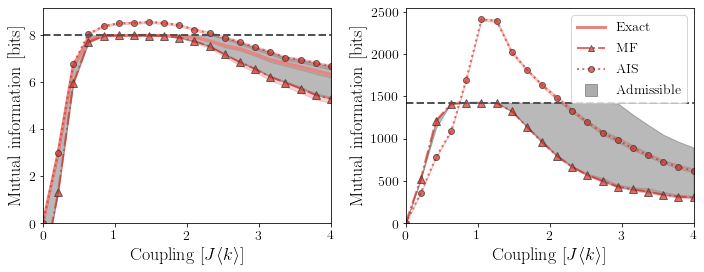

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# t_index = np.where(np.array(T) == 100)[0][0]
# ec_index = np.where(np.array(E) == 5)[0][0]
# ec = E[ec_index]
# t = T[t_index]
color_exact = display.light_colors["red"]
color_mf = display.med_colors["red"]
color_ais = display.med_colors["red"]
color_lines = display.dark_colors["grey"]

mi = {} 
hg = {}
for key, exp in small_exp.items():
    mi[key] = midynet.metrics.Statistics({
        k: exp.metrics["mutualinfo"].data[exp.name][f"mi-{k}"] 
        for k in ["mid", "high", "low"]
    })
    hg[key] = midynet.metrics.Statistics({
        k: exp.metrics["mutualinfo"].data[exp.name][f"hg-{k}"] 
        for k in ["mid", "high", "low"]
    })

plot(ax[0], small_xaxis["exact"], mi["exact"], 
    fill_alpha=0.3, 
    color=color_exact,
    linestyle="-",
    linewidth=3,
    marker="None",
)

plot(ax[0], small_xaxis["meanfield"], mi["meanfield"], 
    fill_alpha=0.3, 
    alpha=0.7, 
    color=color_mf,
    markeredgecolor=color_lines, 
    fill_color=color_mf, 
    linestyle="-.",
    linewidth=2,
    marker="^",
    markersize=8,
    spacing=1,
)

plot(ax[0], small_xaxis["annealed"], mi["annealed"], 
    fill_alpha=0.3, 
    alpha=0.7, 
    color=color_ais,
    markeredgecolor=color_lines, 
    linestyle="dotted",
    linewidth=2,
    marker="o",
    markersize=6,
    spacing=1,
)

y1 = np.clip(mi["meanfield"]["mid"], -10, hg["meanfield"]["mid"])
y2 = np.clip(mi["annealed"]["mid"], -10, hg["annealed"]["mid"])
ax[0].fill_between(small_xaxis["meanfield"], y1, y2, color=display.med_colors["grey"], alpha=0.4)
ax[0].plot(small_xaxis["meanfield"], hg["meanfield"]["mid"], linestyle="--", marker="None", color=display.med_colors["grey"], linewidth=2)
ax[0].set_xlim([xmin, xmax])
ax[0].set_ylim([0, ax[0].get_ylim()[-1]])
ax[0].set_xlabel(xlabel, fontsize=18)
ax[0].set_ylabel("Mutual information [bits]", fontsize=18)

mi = {} 
hg = {}
for key, exp in large_exp.items():
    mi[key] = midynet.metrics.Statistics({
        k: exp.metrics["mutualinfo"].data[exp.name][f"mi-{k}"] 
        for k in ["mid", "high", "low"]
    })
    hg[key] = midynet.metrics.Statistics({
        k: exp.metrics["mutualinfo"].data[exp.name][f"hg-{k}"] 
        for k in ["mid", "high", "low"]
    })

plot(ax[1], large_xaxis["meanfield"], mi["meanfield"], 
    fill_alpha=0.3, 
    alpha=0.7, 
    color=color_mf,
    markeredgecolor=color_lines, 
    fill_color=color_mf, 
    linestyle="-.",
    linewidth=2,
    marker="^",
    markersize=8,
    spacing=1,
)

plot(ax[1], large_xaxis["annealed"], mi["annealed"] * np.log(2), 
    fill_alpha=0.3, 
    alpha=0.7, 
    color=color_ais,
    markeredgecolor=color_lines, 
    linestyle="dotted",
    linewidth=2,
    marker="o",
    markersize=6,
    spacing=1,
)

y1 = np.clip(mi["meanfield"]["mid"], -10, hg["meanfield"]["mid"])
y2 = np.clip(mi["annealed"]["mid"], -10, hg["annealed"]["mid"])
ax[1].fill_between(large_xaxis["meanfield"], y1, y2, color=display.med_colors["grey"], alpha=0.4)
ax[1].plot(large_xaxis["meanfield"], hg["meanfield"]["mid"], linestyle="--", marker="None", color=display.med_colors["grey"], linewidth=2)
ax[1].set_xlim([xmin, xmax])
ax[1].set_ylim([0, ax[1].get_ylim()[-1]])
ax[1].set_xlabel(xlabel, fontsize=18)
ax[1].set_ylabel("Mutual information [bits]", fontsize=18)



handles = [
    Line2D([0], [0], color=color_exact, linestyle="-", marker="None", linewidth=3, label=r"Exact"),
    Line2D([0], [0], color=color_mf, markeredgecolor=color_lines, linestyle="-.", marker="^", linewidth=2, markersize=6, alpha=0.7, label=r"MF"),
    Line2D([0], [0], color=color_ais, markeredgecolor=color_lines, linestyle="dotted", marker="o", linewidth=2, markersize=6, alpha=0.7, label=r"AIS"),
    Line2D([0], [0], color=display.dark_colors["grey"], alpha=0.4, linestyle="None", marker="s", markersize=12, label=r"Admissible"),
]
ax[1].legend(handles=handles, fontsize=14, loc="upper right")

fig.tight_layout()

# fig.savefig(path_to_figures + "/svg/p1-figure3.svg")
# fig.savefig(path_to_figures + "/png/p1-figure3.png")
# fig.savefig(path_to_figures + "/pdf/p1-figure3.pdf")

In [3]:
dynamics = "ising"
path_to_data = {
#     "exact": pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/figure2/exact-{dynamics}/"),
    "small-mf": pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/figure3/figure3-small-{dynamics}.meanfield/"),
    "small-ais": pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/figure3/figure3-small-{dynamics}.annealed/"),
    "large-mf": pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/figure3/figure3-large-{dynamics}.meanfield/"),
    "large-ais": pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/figure3/figure3-large-{dynamics}.annealed/"),
}
exp = {k: midynet.experiments.Experiment.load_from_file(p / "config.pickle") for k, p in path_to_data.items()}

# exp = midynet.experiments.Experiment.load_from_file(path_to_data / "config.pickle")

if dynamics == "sis":
    xlabel = r"Infection probability $[\alpha]$"
elif dynamics == "cowan":
    xlabel = r"Activity gain $[\nu\langle k \rangle]$"
elif dynamics == "ising":
    xlabel = r"Coupling $[J\langle k \rangle]$"

# N = exp["exact"].config.graph.size
# E = exp["exact"].config.graph.edge_count.state
# T = exp["exact"].config.dynamics.num_steps

# x_exact = exp["exact"].config.dynamics.get_coupling()
x_small = exp["small-mf"].config.dynamics.get_coupling()
x_large = exp["large-mf"].config.dynamics.get_coupling()

if dynamics == "sis":
    xmin, xmax = 0, 1
else:
    xmin, xmax = 0, 4
ymin, ymax = 0, 1.1


## Figure 3

AttributeError: 'Experiment' object has no attribute 'items'

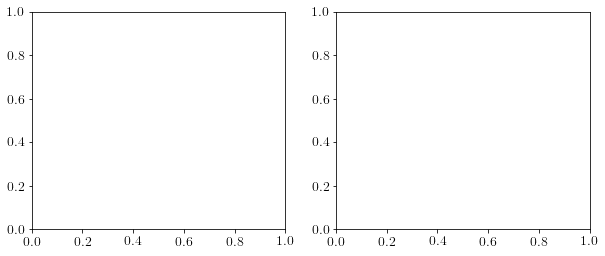

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# t_index = np.where(np.array(T) == 100)[0][0]
# ec_index = np.where(np.array(E) == 5)[0][0]
# ec = E[ec_index]
# t = T[t_index]
color_exact = display.med_colors["blue"]
color_mf = display.med_colors["blue"]
color_ais = display.med_colors["blue"]
color_lines = display.med_colors["grey"]

bit_ratio = np.log(2)
hg = {key: midynet.metrics.Statistics({k: _exp.metrics["mutualinfo"].data[_exp.name][f"hg-{k}"] for k in ["mid", "high", "low"]}) / bit_ratio for key, _exp in exp.items()}
hgx = {key: midynet.metrics.Statistics({k: _exp.metrics["mutualinfo"].data[_exp.name][f"hgx-{k}"] for k in ["mid", "high", "low"]}) / bit_ratio for key, _exp in exp.items()}
# hg["exact"] = midynet.metrics.Statistics(hg["exact"][t_index, :, ec_index])
# hgx["exact"] = midynet.metrics.Statistics(hgx["exact"][t_index, :, ec_index])
mi = {key: hg[key] - hgx[key] for key in exp.keys()}

# midynet.metrics.Statistics.plot(
#     ax[0], x_exact, mi["exact"], 
#     fill_alpha=0.3, 
#     color=color_exact,
#     linestyle="-",
#     linewidth=2,
#     marker="None",
# )

plot(
    ax[0], x_small, mi["small-mf"], 
    fill_alpha=0.3, 
    color=color_lines,
    markerfacecolor=color_mf, 
    linestyle="-.",
    linewidth=2,
    marker="^",
)

plot(
    ax[0], x_small, mi["small-ais"], 
    fill_alpha=0.3, 
    color=color_lines,
    markerfacecolor=color_ais, 
    linestyle="dotted",
    linewidth=2,
    marker="o",
)

y1 = np.clip(mi["small-mf"]["mid"], 0, hg["small-mf"]["mid"])
y2 = np.clip(mi["small-ais"]["mid"], 0, hg["small-ais"]["mid"])
ax[0].fill_between(x_small, y1, y2, color=display.dark_colors["grey"], alpha=0.4)
ax[0].plot(x_small, hg["small-mf"].__data__["mid"], linestyle="--", marker="None", color=display.dark_colors["grey"], linewidth=2)
ax[0].set_xlim([xmin, xmax])
ax[0].set_ylim([0, ax[0].get_ylim()[1]])
ax[0].set_xlabel(xlabel, fontsize=18)
ax[0].set_ylabel(r"Mutual information [bits]", fontsize=18)
ax[0].tick_params(axis='both', labelsize=14)
display.label_plot(ax[0], r"\textbf{(a)}", loc="lower right", fontsize=18)

plot(
    ax[1], x_large, mi["large-mf"], 
    fill_alpha=0.3, 
    color=color_mf,
    linestyle="-.",
    linewidth=2,
    marker="^",
)

plot(
    ax[1], x_large, mi["large-ais"], 
    fill_alpha=0.3, 
    color=color_ais,
    linestyle="dotted",
    linewidth=2,
    marker="o",
)

y1 = np.clip(mi["large-mf"]["mid"], 0, hg["large-mf"]["mid"])
y2 = np.clip(mi["large-ais"]["mid"], 0, hg["large-ais"]["mid"])
ax[1].fill_between(x_large, y1, y2, color=display.dark_colors["grey"], alpha=0.4)
ax[1].plot(x_large, hg["large-mf"].__data__["mid"], linestyle="--", marker="None", color=display.dark_colors["grey"], linewidth=2)
ax[1].set_xlim([xmin, xmax])
ax[1].set_ylim([0, ax[1].get_ylim()[1]])
ax[1].set_xlabel(xlabel, fontsize=18)
ax[1].set_ylabel(r"Mutual information [bits]", fontsize=18)
ax[1].tick_params(axis='both', labelsize=14)
display.label_plot(ax[1], r"\textbf{(b)}", loc="lower right", fontsize=18)



# x_mf = exp["large-meanfield"].config.dynamics.j
# y_mf = exp["large-meanfield"].metrics["MutualInformationMetrics"].data
# get_plot(
#     exp["large-meanfield"].config.dynamics.j, 
#     y_mf, 
#     ax=ax[1], 
#     norm=1/(np.log2(np.exp(1))),
#     fill_alpha=0.3,
#     color="k",
#     markerfacecolor=color_mf, 
#     linestyle="-.", 
#     linewidth=2,
#     marker="^",
# )

# x_ais = exp["large-annealed"].config.dynamics.j
# y_ais = exp["large-annealed"].metrics["MutualInformationMetrics"].data
# get_plot(
#     x_ais, 
#     y_ais, 
#     ax=ax[1], 
#     norm=1/(np.log2(np.exp(1))),
#     fill_alpha=0.3,
#     linewidth=2,
#     color="k",
#     markerfacecolor=color_ais, 
#     linestyle="dotted", 
#     marker="o",
# )

# x = np.linspace(0, 4, 100)
# f1, f2 = interp1d(x_mf, y_mf["mid"]), interp1d(x_ais, y_ais["mid"])

# y1 = np.clip(f1(x), 0, exp["large-meanfield"].metrics["GraphEntropyMetrics"].data["mid"][0]) * np.log2(np.exp(1))
# y2 = np.clip(f2(x), 0, exp["large-annealed"].metrics["GraphEntropyMetrics"].data["mid"][0]) * np.log2(np.exp(1))
# ax[1].fill_between(x, y1, y2, color=display.dark_colors["grey"], alpha=0.5)
# ax[1].set_xlim([xmin, 4])
# ax[1].set_ylim([0, ax[1].get_ylim()[1]])
# ax[1].set_xlabel(r"Coupling $\left[J\langle k \rangle\right]$", fontsize=18)
# ax[1].set_ylabel(r"Mutual information [bits]", fontsize=18)
# ax[1].tick_params(axis='both', labelsize=14)
# ax[1].plot(
#     exp["large-meanfield"].config.dynamics.j,
#     exp["large-annealed"].metrics["GraphEntropyMetrics"].data["mid"] * np.log2(np.exp(1)),
#     linestyle="--",
#     marker="None",
#     color=display.dark_colors["grey"],
#     linewidth=2
# )
# display.label_plot(ax[1], r"\textbf{(b)}", loc="lower right", fontsize=18)

# handles = [
#     mpl.lines.Line2D([0], [0], color=color_exact, linestyle="-", marker="None", linewidth=2, label=r"Exact"),
#     mpl.lines.Line2D([0], [0], color="k", markerfacecolor=color_mf, linestyle="-.", marker="^", linewidth=2, label=r"MF"),
#     mpl.lines.Line2D([0], [0], color="k", markerfacecolor=color_ais, linestyle="dotted", marker="o", linewidth=2, label=r"AIS"),
#     mpl.lines.Line2D([0], [0], color=display.dark_colors["grey"], alpha=0.4, linestyle="None", marker="s", markersize=12, label=r"Admissible"),
# ]
# ax[1].legend(handles=handles, fontsize=14, loc="upper right")

fig.tight_layout()

# fig.savefig(path_to_figures + "/svg/p1-figure3.svg")
# fig.savefig(path_to_figures + "/png/p1-figure3.png")
# fig.savefig(path_to_figures + "/pdf/p1-figure3.pdf")

In [9]:
print(exp["large-ais"].config.format())

ExperimentConfig(name=`figure3-large-ising.annealed`): 
|	dynamics(name=`ising`): 
|	|	num_steps = 1000
|	|	coupling = [0.0, 0.21052631578947367, 0.42105263157894735, 0.631578947368421, 0.8421052631578947, 1.0526315789473684, 1.263157894736842, 1.4736842105263157, 1.6842105263157894, 1.894736842105263, 2.1052631578947367, 2.3157894736842106, 2.526315789473684, 2.7368421052631575, 2.9473684210526314, 3.1578947368421053, 3.3684210526315788, 3.578947368421052, 3.789473684210526, 4.0]
|	|	normalize = True
|	end
|	graph(name=`ser`): 
|	|	size = 100
|	|	edge_count(name=`delta`) 
|	|	|	state = 250
|	|	end
|	|	edge_proposer(name=`hinge_flip_uniform`) 
|	|	|	allow_self_loops = False
|	|	|	allow_multiedges = False
|	|	end
|	|	sample_graph_prior_prob = 0.0
|	end
|	metrics(name=`config`): 
|	|	mutualinfo(name=`mutualinfo`) 
|	|	|	num_sweeps = 500
|	|	|	error_type = `confidence`
|	|	|	method = `annealed`
|	|	|	num_samples = 32
|	|	|	burn_per_vertex = 5
|	|	|	initial_burn = 2000
|	|	|	reset_to_origi